In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

sns.set(style="whitegrid")

In [2]:
#Load datasets
load_df = pd.read_excel('/Datasets/hourlyLoadDataIndia.xlsx')
temp_df = pd.read_excel('/Datasets/monthly_temp.xlsx')

In [3]:
# Convert datetime to pandas datetime
load_df['datetime'] = pd.to_datetime(load_df['datetime'])
load_df['year'] = load_df['datetime'].dt.year
load_df['month'] = load_df['datetime'].dt.month
load_df['hour'] = load_df['datetime'].dt.hour
load_df['dayofweek'] = load_df['datetime'].dt.dayofweek

# Merge temperature data
temp_df['month'] = pd.to_datetime(temp_df['Month'], format='%b').dt.month
temp_df['Year'] = temp_df['Year'].astype(int)
load_df = pd.merge(load_df, temp_df.rename(columns={'Year': 'year'}), on=['year', 'month'], how='left')

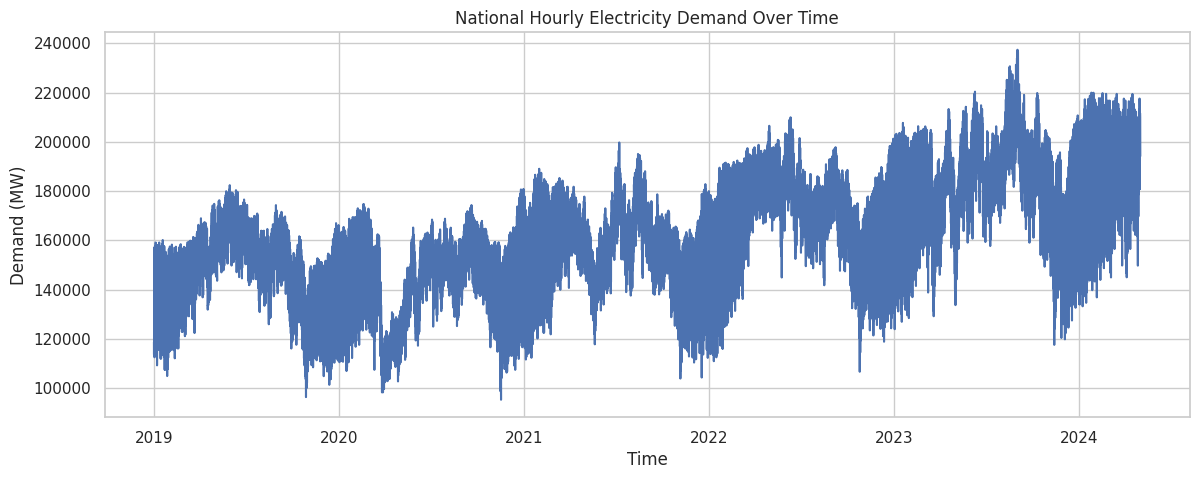

In [4]:
#EDA
plt.figure(figsize=(14,5))
sns.lineplot(data=load_df, x="datetime", y="National Hourly Demand")
plt.title("National Hourly Electricity Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.show()

###Random Forest

MAE: 8336.296149885799
RMSE: 10948.102120474427


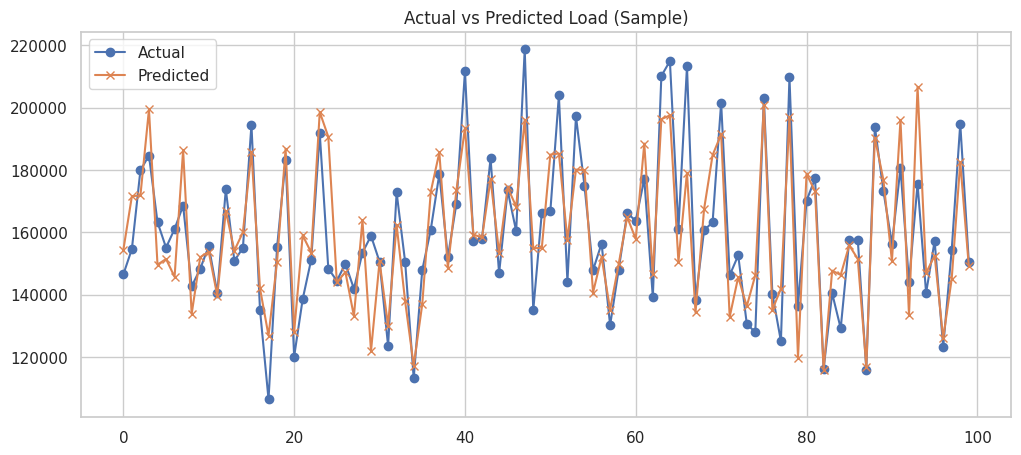

In [5]:
#RandomForest Model
features = ['hour', 'dayofweek', 'month', 'max_temp']
target = 'National Hourly Demand'

X = load_df[features]
y = load_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Plot predictions
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title("Actual vs Predicted Load (Sample)")
plt.legend()
plt.show()

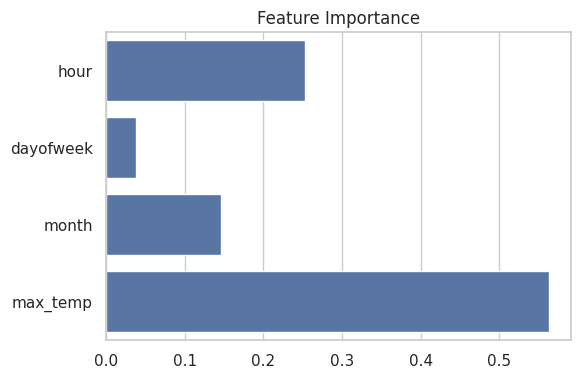

In [6]:
#Feature Importance
importances = model.feature_importances_
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

###Prophet

In [15]:
from prophet import Prophet

In [16]:
df_prophet = load_df[['datetime', 'National Hourly Demand']].rename(columns={
    'datetime': 'ds',
    'National Hourly Demand': 'y'
})

In [17]:
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcyheo31j/ct35wsca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcyheo31j/nv2or0ap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58094', 'data', 'file=/tmp/tmpcyheo31j/ct35wsca.json', 'init=/tmp/tmpcyheo31j/nv2or0ap.json', 'output', 'file=/tmp/tmpcyheo31j/prophet_modelwi2iiqpz/prophet_model-20250614051917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
future = prophet_model.make_future_dataframe(periods=48, freq='H')
forecast = prophet_model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


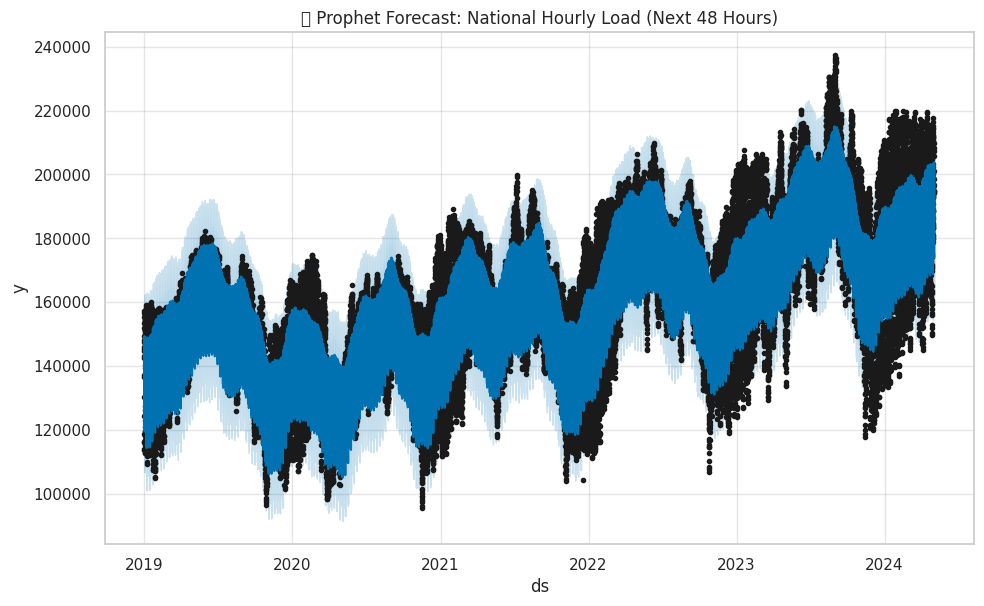

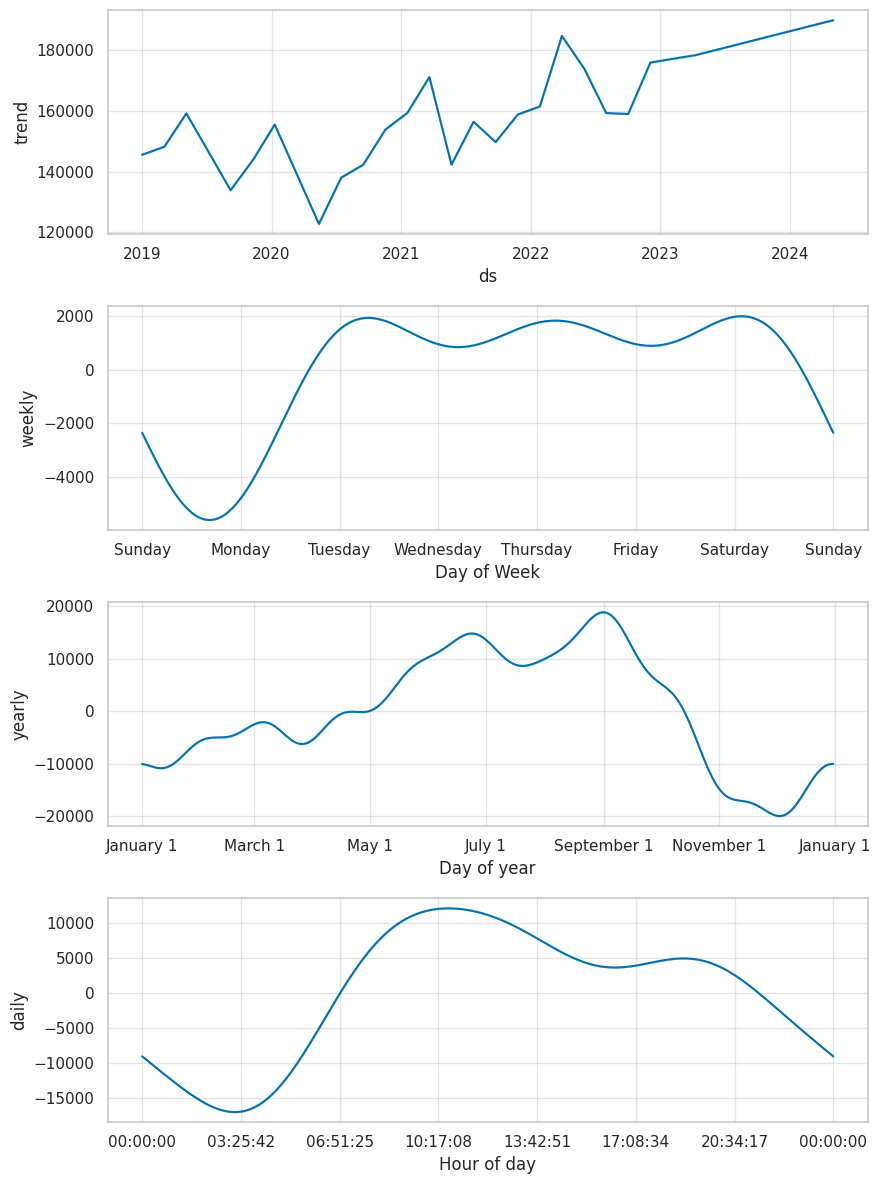

In [19]:
fig1 = prophet_model.plot(forecast)
plt.title("🔮 Prophet Forecast: National Hourly Load (Next 48 Hours)")
plt.show()

fig2 = prophet_model.plot_components(forecast)
plt.show()

In [20]:
merged_df = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')
prophet_mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))

print(f"📉 Prophet MAE: {prophet_mae:.2f}")
print(f"📉 Prophet RMSE: {prophet_rmse:.2f}")

📉 Prophet MAE: 8511.57
📉 Prophet RMSE: 10523.53


###Region-Specific Forecast

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcyheo31j/x577ybdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcyheo31j/oqxltep0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48558', 'data', 'file=/tmp/tmpcyheo31j/x577ybdv.json', 'init=/tmp/tmpcyheo31j/oqxltep0.json', 'output', 'file=/tmp/tmpcyheo31j/prophet_model_jrtp392/prophet_model-20250614053935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:39:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:40:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


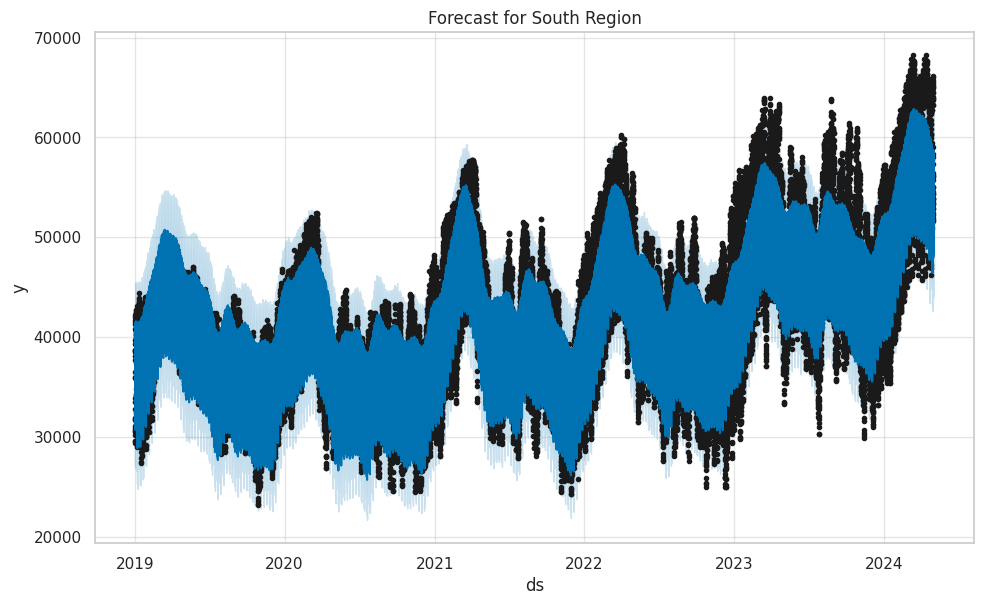

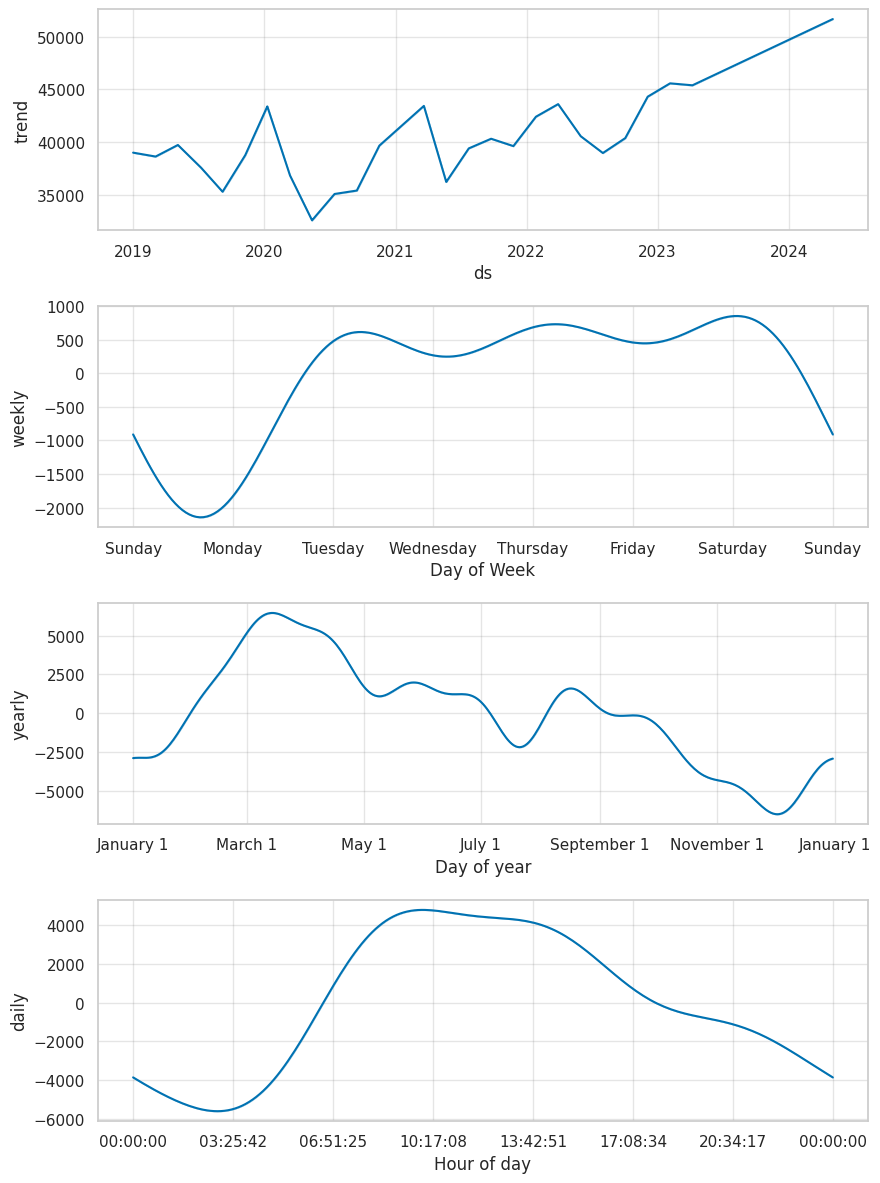

In [21]:
region_map = {
    "National": "National Hourly Demand",
    "North": "Northen Region Hourly Demand",
    "West": "Western Region Hourly Demand",
    "East": "Eastern Region Hourly Demand",
    "South": "Southern Region Hourly Demand",
    "North-East": "North-Eastern Region Hourly Demand"
}

selected_region = "South"  # 🔁 Change this to experiment with other regions
target_column = region_map[selected_region]

df_region = load_df[['datetime', target_column]].rename(columns={
    'datetime': 'ds',
    target_column: 'y'
})

region_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
region_model.fit(df_region)

future_region = region_model.make_future_dataframe(periods=48, freq='H')
forecast_region = region_model.predict(future_region)

fig = region_model.plot(forecast_region)
plt.title(f"Forecast for {selected_region} Region")
plt.show()

fig2 = region_model.plot_components(forecast_region)
plt.show()

In [22]:
#Evaluation for Regional Forecast

from sklearn.metrics import mean_absolute_error, mean_squared_error

merged_region = pd.merge(df_region, forecast_region[['ds', 'yhat']], on='ds')
mae = mean_absolute_error(merged_region['y'], merged_region['yhat'])
rmse = np.sqrt(mean_squared_error(merged_region['y'], merged_region['yhat']))

print(f"📉 {selected_region} MAE: {mae:.2f}")
print(f"📉 {selected_region} RMSE: {rmse:.2f}")

📉 South MAE: 2477.67
📉 South RMSE: 3081.94


###Energy Efficiency Recommendation

In [23]:
def get_energy_recommendation(load_value):
    if load_value > 160000:
        return "⚠️ Extremely High Load — Suggest industrial load shifting, avoid peak hour usage."
    elif load_value > 140000:
        return "🔺 High Load — Encourage public to reduce AC use and turn off idle devices."
    elif load_value > 120000:
        return "🟡 Moderate Load — Promote LED bulbs, avoid unnecessary daytime lighting."
    else:
        return "🟢 Normal Load — Maintain standard energy use."

# Apply to last predicted hour
predicted_load = forecast_region.iloc[-1]['yhat']
recommendation = get_energy_recommendation(predicted_load)

print(f"Predicted Load: {predicted_load:.2f} MW")
print(f"💡 Recommendation: {recommendation}")

Predicted Load: 50662.71 MW
💡 Recommendation: 🟢 Normal Load — Maintain standard energy use.
